In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

## Load Dataset

In [13]:
data_path = '/kaggle/input/plant-pathology-2020-fgvc7/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

train.shape, test.shape

((1821, 5), (1821, 1))

## EDA

### Distribution of dataset

516 91 622 592


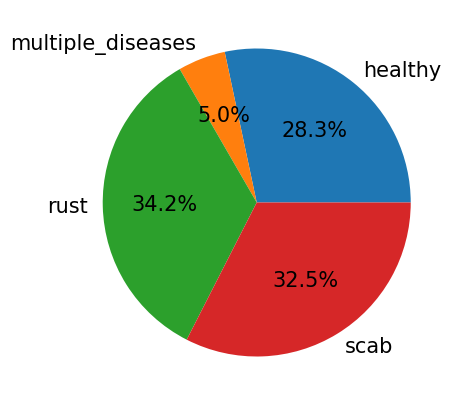

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

healthy, multiple_diseases, rust, scrab = train.select_dtypes(int).sum().to_list()
print(healthy, multiple_diseases, rust, scrab)

mpl.rc('font', size = 15)
plt.figure(figsize = (5,5))

label = train.select_dtypes(int).columns.to_list()

plt.pie([healthy, multiple_diseases, rust, scrab],
        labels = label,
        autopct='%.1f%%')
plt.show()

### Print image sample

In [4]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_ids, rows=2, cols=3):
    assert len(img_ids) <= rows * cols
    
    plt.figure(figsize = (12, 4))
    grid = gridspec.GridSpec(rows, cols)
    
    for idx, img_id in enumerate(img_ids):
        img_path = f'{data_path}/images/{img_id}.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)
    plt.show()
    
num_of_imgs = 6
last_healthy_img_ids = train.loc[train.healthy == 1, 'image_id'][-num_of_imgs:]
last_multiple_diseases_img_ids = train.loc[train.multiple_diseases == 1, 'image_id'][-num_of_imgs:]
last_rust_img_ids = train.loc[train.rust == 1, 'image_id'][-num_of_imgs:]
last_scab_img_ids = train.loc[train.scab == 1, 'image_id'][-num_of_imgs:]


In [ ]:
show_image(last_healthy_img_ids)

In [ ]:
show_image(last_multiple_diseases_img_ids)

In [ ]:
show_image(last_rust_img_ids)

In [ ]:
show_image(last_scab_img_ids)

# Model

## Fix seed value for model reproducibility

In [9]:
import torch
import random
import numpy as np
import os

seed = 50
os.environ['PYPTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False


## Setup GPU device

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Prepare dataset

In [14]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train,
                               test_size = 0.1,
                               stratify=train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                               random_state = 50)

## Dataset class

In [15]:
import cv2
from torch.utils.data import Dataset
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir,
        self.transform = transform,
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id + '.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
           image = self.transform(image = image)['image'] 
        if self.is_test:
            return image
        else:
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label